## scikeras Keras regressor integration

The integration of KerasRegressor in pipeline is limited. To use full keras capabilities, you may need to modify the pipeline.

In [2]:
# Standard loading and preprocessing code

from pinard import nirs_set as n_set
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
from pinard.nirs_pipelines import FeatureAugmentation


# Init basic random
rd_seed = 42
np.random.seed(rd_seed)
tf.random.set_seed(rd_seed)
random.seed(rd_seed)
# tf.config.experimental.enable_op_determinism()
# tf.config.experimental.disable_op_determinism()




# Create a set named data
n = n_set.NIRS_Set('data')
X_train, y_train = n.load('gilles/Xcal.csv', 'gilles/Ycal.csv', y_cols=0)
X_test, y_test = n.load('gilles/Xval.csv', 'gilles/Yval.csv', y_cols=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


from pinard import preprocessor as pp
from sklearn.pipeline import Pipeline

preprocessing = [   ('id', pp.IdentityTransformer()),
                    ('baseline', pp.StandardNormalVariate()),
                    ('savgol', pp.SavitzkyGolay()),
                    ('gaussian1', pp.Gaussian(order = 1, sigma = 2)),
                    ('gaussian2', pp.Gaussian(order = 2, sigma = 1)),
                    ('haar', pp.Wavelet('haar')),
                    ('coif3', pp.Wavelet('coif3')),
                    ('detrend', pp.Detrend()),
                    ('msc', pp.MultiplicativeScatterCorrection(scale=False)),
                    ('dv1', pp.Derivate(1,1)),
                    ('dv2', pp.Derivate(2,1)),
                    ('dv3', pp.Derivate(2,2)),
                    
                    ('baseline*savgol', Pipeline([('_sg1',pp.StandardNormalVariate()),('_sg2',pp.SavitzkyGolay())])),
                    ('baseline*gaussian1', Pipeline([('_sg1',pp.StandardNormalVariate()),('g2', pp.Gaussian(order = 1, sigma = 2) )])),
                    ('baseline*gaussian2', Pipeline([('_sg1',pp.StandardNormalVariate()),('g2', pp.Gaussian(order = 2, sigma = 1) )])),
                    ('baseline*haar', Pipeline([('_sg1',pp.StandardNormalVariate()),('_sg2',pp.Wavelet('haar'))])),
                    
                    # ('savgol*savgol', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.SavitzkyGolay())])),
                    # ('savgol*baseline', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.StandardNormalVariate())])),
                    # ('savgol*gaussian1', Pipeline([('_sg1',pp.SavitzkyGolay()),('g2', pp.Gaussian(order = 1, sigma = 2) )])),
                    # ('savgol*gaussian2', Pipeline([('_sg1',pp.SavitzkyGolay()),('g2', pp.Gaussian(order = 2, sigma = 1) )])),
                    # ('savgol*haar', Pipeline([('_sg1',pp.SavitzkyGolay()), ('haar', pp.Wavelet('haar'))])),
                    ('gaussian1*savgol', Pipeline([('_g1',pp.Gaussian(order = 1, sigma = 2)),('_sg3',pp.SavitzkyGolay())])),
                    ('gaussian2*savgol', Pipeline([('_g2',pp.Gaussian(order = 1, sigma = 2)),('_sg4',pp.SavitzkyGolay())])),
                    # ('haar*savgol', Pipeline([('_haar2',pp.Wavelet('haar')),('_sg5',pp.SavitzkyGolay())])),
                    ('haar*gaussian1', Pipeline([('_haar2',pp.Wavelet('haar')), ('g2', pp.Gaussian(order = 1, sigma = 2)) ])),
                    # ('haar*gaussian2', Pipeline([('_haar2',pp.Wavelet('haar')), ('g2', pp.Gaussian(order = 2, sigma = 1)) ])),
                ]

y_scaler = MinMaxScaler()
y_scaler.fit(y_train.reshape((-1,1)))
y_train = y_scaler.transform(y_train.reshape((-1,1)))
y_valid = y_scaler.transform(y_test.reshape((-1,1)))

transformer_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('preprocessing', FeatureAugmentation(preprocessing)), 
])

transformer_pipeline.fit(X_train)
X_train = transformer_pipeline.transform(X_train)
X_valid = transformer_pipeline.transform(X_test)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(226, 949) (226,) (76, 949) (76,)
TRANSFORM
ahahah (226, 949, 19)
TRANSFORM
ahahah (76, 949, 19)
(226, 949, 19) (226, 1) (76, 949, 19) (76, 1)


## Complex pipeline

In the following example we will declare a custom callback, un custom optimizer and we will use test data as validation metrics for the keras model.

### Custom Adam optimizer with Cyclic Learning Rate

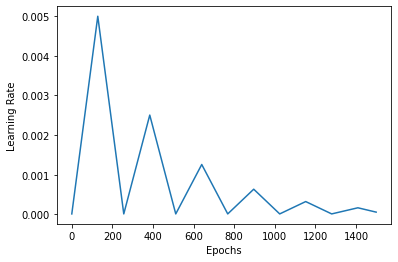

In [3]:
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

import matplotlib.pyplot as plt

BATCH_SIZE = 64
EPOCHS = 1500
# MIN_LR = 5e-7
# MAX_LR = 1e-3

MIN_LR = 1e-5
MAX_LR = 5e-3
CYCLE_LENGTH = 128

steps_per_epoch = len(X_train) // BATCH_SIZE

# Define the learning rate cycle properties
clr = CyclicalLearningRate(
    initial_learning_rate=MIN_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size= CYCLE_LENGTH * steps_per_epoch
)

optimizer = Adam(clr)

# Display learning rate evolution
epochs = np.arange(0, EPOCHS)
lr = clr(steps_per_epoch * epochs)
plt.plot(epochs, lr)
plt.rcParams["figure.figsize"] = (3,6)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.show()


# custom Keras Callback that store 
class Auto_Save(Callback):
    best_weights = []
    
    def __init__(self):
        super(Auto_Save, self).__init__()
        self.best = np.Inf
                
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if np.less(current_loss, self.best):
            self.best = current_loss            
            Auto_Save.best_weights = self.model.get_weights()
            
    def on_train_end(self, logs=None):
        if self.params['verbose'] == 2:
            print('\nSaved best {0:6.4f}\n'.format(self.best))
            
            

class Print_LR(Callback):
    def __init__(self, clr):
        self.clr = clr
        
    def on_epoch_end(self, epoch, logs=None):
        iteration = self.model.optimizer.iterations.numpy()
        lr = self.clr(iteration).numpy()
        if self.params['verbose'] == 2:
            print("Iteration {} - Learning rate: {}".format(iteration, lr) )
            
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from pinard.nirs_pipelines import FeatureAugmentation
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
import math
import callbacks as cb


early_stop = EarlyStopping(monitor='val_loss', patience=400, verbose=0, mode='min') 

In [9]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Concatenate,GlobalAveragePooling1D, Conv1D, Activation, SpatialDropout1D,SeparableConv1D,Flatten, Dropout, Input, MaxPooling1D, DepthwiseConv1D, BatchNormalization, AveragePooling1D



def separable(hp, model, i, multiplier):
    # kernel = hp.Int('kernel' + str(i), min_value=1, max_value=21, step=2)
    # filters = hp.Choice('filters' + str(i), [8,16,32,64,128])
    # multiplier = hp.Choice('multiplier' + str(i), multiplier)
    # activation = hp.Choice('activation' + str(i), ["relu", "swish", "leaky_relu"])
    kernel = 7
    filters = 32
    multiplier = 2
    activation = "relu"
    model.add(SeparableConv1D(filters, kernel_size=kernel, depth_multiplier=multiplier, padding="same", activation=activation))
    model.add(AveragePooling1D(pool_size=4,strides=2))

def model_builder(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    
    # sp_drop_1 = hp.Float('sp_drop_1', min_value=0, max_value=0.8)
    sp_drop_1 = 0.2
    model.add(SpatialDropout1D(sp_drop_1))
    
    n_sep_layers = hp.Int('n_layers', min_value=1, max_value=5)
    for i in range(n_sep_layers):
        separable(hp, model, i, 2)
    # separable(hp, model, 1, [1,2])
    # with hp.conditional_scope("n_layers", [2,3,4,5]):
    # separable(hp, model, 2, [1,2])
    # separable(hp, model, 3, [1,2,4])
    # separable(hp, model, 4, [1,2,4])
    
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4,strides=2))
    
    # sp_drop_2 = hp.Float('sp_drop_2', min_value=0, max_value=0.8)
    # model.add(SpatialDropout1D(sp_drop_2))
    
    model.add(Flatten())
    units_1 = hp.Choice('units_1', [8,16,32,64,128])
    # units_1 = 64
    model.add(Dense(units=units_1, activation="relu"))
    
    # drop_1 = hp.Float('sp_drop_2', min_value=0, max_value=0.5)
    # model.add(Dropout(drop_1))
    
    units_2 = hp.Choice('units_2', [8,16,32,64,128])
    # units_2 = 32
    model.add(Dense(units=units_2, activation="relu"))
    
    final_activation = hp.Choice('dactivation', ["linear", "sigmoid"])
    model.add(Dense(units=1, activation=final_activation))
    
    model.compile(loss = 'mean_squared_error', metrics=['mse'], optimizer = optimizer)
    model.summary()
    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=1500,
                     factor=3,
                     hyperband_iterations = 10,
                     directory='my_dir',
                     project_name='bacon_vg_layers')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300)
tuner.search(X_train, y_train, epochs=1500, validation_data=(X_valid, y_valid))#, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

Trial 220 Complete [00h 00m 04s]
val_loss: 0.08998116850852966

Best val_loss So Far: 0.02125328592956066
Total elapsed time: 00h 15m 38s
INFO:tensorflow:Oracle triggered exit


In [11]:
best_model = tuner.get_best_models()[0]
# print(best_hps)
# import json
json_formatted_str = json.dumps(best_model.get_config(), indent=4)
print(json_formatted_str)
# best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d (SpatialD  (None, 949, 19)          0         
 ropout1D)                                                       
                                                                 
 separable_conv1d (Separable  (None, 949, 32)          1514      
 Conv1D)                                                         
                                                                 
 average_pooling1d (AverageP  (None, 473, 32)          0         
 ooling1D)                                                       
                                                                 
 separable_conv1d_1 (Separab  (None, 473, 32)          2528      
 leConv1D)                                                       
                                                                 
 average_pooling1d_1 (Averag  (None, 235, 32)          0